In [5]:
import os
import torch
import numpy as np
import torchvision
from PIL import Image
import matplotlib.pyplot as plt

import torchvision.transforms as T
import torch.nn.functional as F

from ig_pkg.datasets import get_datasets

from ig_pkg.models.generator import get_model
from ig_pkg.models.classifier import get_classifier
from ig_pkg.models.pretrained_models import get_pretrained_model

from ig_pkg.inputattribs.ig import ig
from ig_pkg.inputattribs.baseline_generator import get_baseline_generator

from ig_pkg.misc import process_heatmap, normalize_tensor, convert_to_img, label_to_class, tran, na_imshow

import time
import torch.nn as nn
import torch.optim as optim
from torch.optim.lr_scheduler import StepLR
from ig_pkg.loss.focal_loss import FocalLoss
from ig_pkg.loss.metrics import ArcMarginProduct, AddMarginProduct
import torchvision.models as models

IMAGENET_MEAN = [0.485, 0.456, 0.406]
IMAGENET_STD  = [0.229, 0.224, 0.225]


In [2]:
data_path="/root/data/ILSVRC2012_val/"

_, valid_datasets = get_datasets("imagenet1k", data_path)
_, valid_datasets2 = get_datasets("imagenet1k", data_path, transform=T.Compose([T.Resize(256),T.CenterCrop(256),]) )

device="cuda:0"
# model = get_pretrained_model("vgg16").to(device)

# train_dataset, valid_dataset = get_datasets(name= 'celebAHQ_identity', data_path = '/root/data/CelebA_HQ_facial_identity_dataset')
# class_names = train_dataset.classes
# np.save('/root/data/celebAHQ_identity_class_names.npy', class_names)
# class_names = np.load('/root/data/celebAHQ_identity_class_names.npy')

# train_dataloader = torch.utils.data.DataLoader(train_dataset, batch_size=32, shuffle=True, num_workers=2)
# test_dataloader = torch.utils.data.DataLoader(valid_dataset, batch_size=16, shuffle=True, num_workers=2)

# image_path = '/root/data/CelebA_HQ_facial_identity_dataset/train'

Transfer Learning using val

In [80]:


# model = models.resnet18(pretrained=True)
model = models.resnet18(weights="ResNet18_Weights.IMAGENET1K_V1")
valid_dataloader = torch.utils.data.DataLoader(valid_datasets, batch_size=32, shuffle=True, num_workers=2)
model = model.to(device)

criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=0.01, momentum=0.9)

num_epochs = 30
start_time = time.time()

for epoch in range(num_epochs):
    """ Training Phase """
    model.train()

    running_loss = 0.
    running_corrects = 0

    # load a batch data of images
    for i, (inputs, labels) in enumerate(valid_dataloader):
        inputs = inputs.to(device)
        labels = labels.to(device)

        # forward inputs and get output
        optimizer.zero_grad()
        outputs = model(inputs)
        _, preds = torch.max(outputs, 1)
        loss = criterion(outputs, labels)

        # get loss value and update the network weights
        loss.backward()
        optimizer.step()

        running_loss += loss.item() * inputs.size(0)
        running_corrects += torch.sum(preds == labels.data)

    epoch_loss = running_loss / len(valid_datasets)
    epoch_acc = running_corrects / len(valid_datasets) * 100.
    print('[Train #{}] Loss: {:.4f} Acc: {:.4f}% Time: {:.4f}s'.format(epoch, epoch_loss, epoch_acc, time.time() - start_time))
    if epoch_acc > 99: break
model.eval()

[Train #0] Loss: 2.7792 Acc: 38.1300% Time: 125.4767s
[Train #1] Loss: 1.8218 Acc: 55.4460% Time: 249.5361s
[Train #2] Loss: 1.2189 Acc: 68.4140% Time: 372.4478s
[Train #3] Loss: 0.7170 Acc: 80.9220% Time: 496.7662s
[Train #4] Loss: 0.3257 Acc: 92.0980% Time: 619.2762s
[Train #5] Loss: 0.1074 Acc: 98.3120% Time: 741.6146s
[Train #6] Loss: 0.0353 Acc: 99.7320% Time: 864.6807s


In [3]:
# n02443484: 40 black-footed_ferret
# n01614925: 398 bald_eagle

ferrot_dir = os.path.join(data_path, 'val', 'n02443484')
ferrot_idx = os.listdir(ferrot_dir)[2]
ferrot_img = Image.open(os.path.join(ferrot_dir, ferrot_idx))

eagle_dir = os.path.join(data_path, 'val', 'n01614925')
eagle_idx = os.listdir(eagle_dir)[1]
eagle_img = Image.open(os.path.join(eagle_dir, eagle_idx))


transform = T.Compose([
    T.Resize(224),
    T.CenterCrop(224),
    T.ToTensor(),
    T.Normalize(mean = IMAGENET_MEAN, std = IMAGENET_STD),
])

ferrot_tensor = transform(ferrot_img)
eagle_tensor = transform(eagle_img)


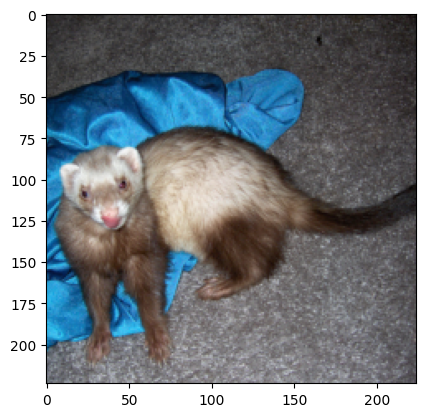

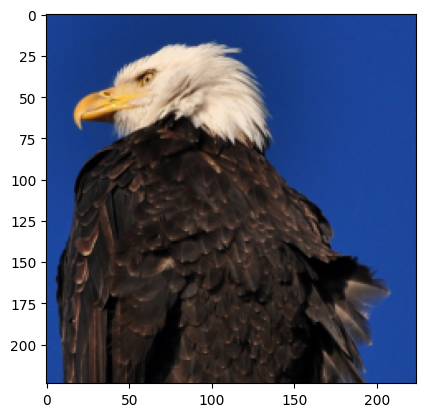

In [87]:
plt.figure()
plt.imshow(convert_to_img(ferrot_tensor))

plt.figure()
plt.imshow(convert_to_img(eagle_tensor))

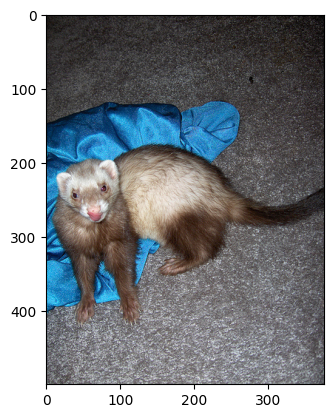

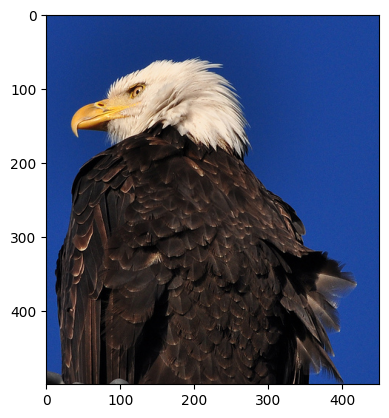

In [68]:
# plt.figure()
# plt.imshow(ferrot_img)

# plt.figure()
# plt.imshow(eagle_img)



In [6]:
model = models.resnet18(pretrained=False)
save_path = f'/root/pretrained/imagenet_val.pth'
model.load_state_dict(torch.load(save_path))
model.eval()


/root/dh/lib/python3.8/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/root/dh/lib/python3.8/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)


ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

In [7]:
model.eval()
score_ferrot = model(ferrot_tensor.unsqueeze(0))
score_eagle = model(eagle_tensor.unsqueeze(0))

_, preds = torch.max(score_ferrot, 1)
print(preds)

_, preds = torch.max(score_eagle, 1)
print(preds)

print(torch.argmax(score_ferrot))
print(torch.argmax(score_eagle))

tensor([359])
tensor([22])
tensor(359)
tensor(22)


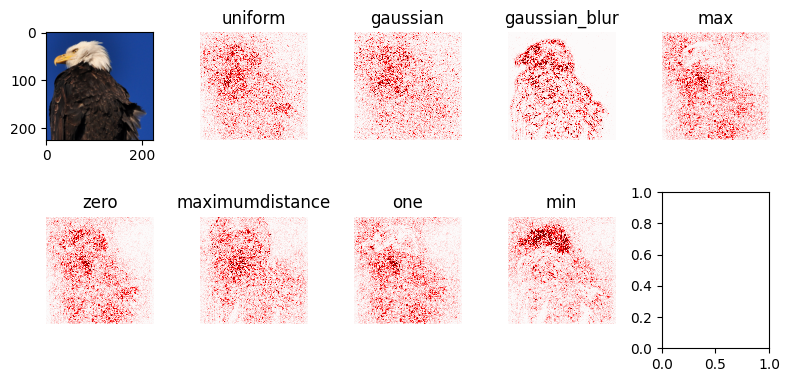

In [11]:

names = {
    'zero',
    'one',
    'min',
    'max',
#     'scalar',
#     'encoder',
#     'optimizer',
#     'hybrid',
    'gaussian_blur',
    'gaussian',
    'uniform',
    'maximumdistance' 
}

index = 0 
# x,y = valid_datasets[index]
x = eagle_tensor
y = preds.item()
import numpy as np
import matplotlib.pyplot as plt 
fig, axes = plt.subplots(2, (len(names)//2)+1, figsize=(2*len(names)//2, 2*2))
axes_flat = axes.flat 
my_cmap=plt.cm.seismic(np.arange(plt.cm.seismic.N))

ax = next(axes_flat)
ax.imshow(convert_to_img(x))

for name in names:
    try:
        b_generator =  get_baseline_generator(name)
        baseline = b_generator(x=x,y=y)

    except Exception as e: 
        print("-----")
        print("fail:", name)
        print(e)
        continue
        
    attr = ig(model.to(device), x, y, baseline, device=device)
    attr, kwargs  = process_heatmap(attr.cpu(), my_cmap)
    ax = next(axes_flat)
    ax.imshow(attr, **kwargs)
    ax.set_title(name)
    ax.axis("off")
plt.tight_layout()

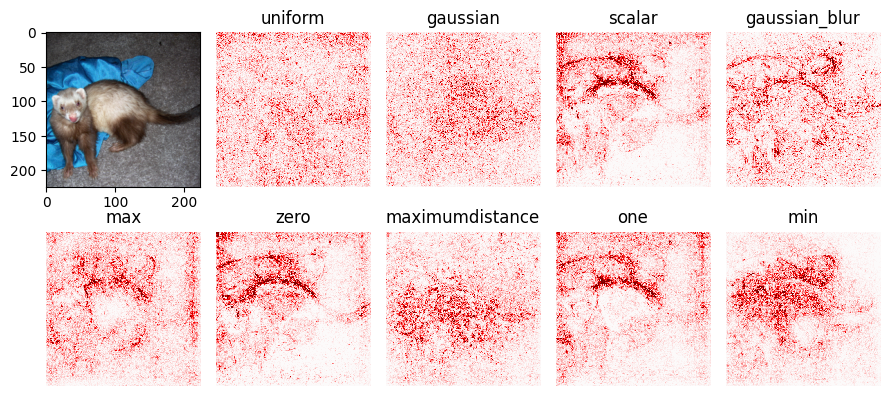

In [16]:

names = {
    'zero',
    'one',
    'min',
    'max',
    'scalar',
#     'encoder',
#     'optimizer',
#     'hybrid',
    'gaussian_blur',
    'gaussian',
    'uniform',
    'maximumdistance' 
}

index = 0 
# x,y = valid_datasets[index]
x = ferrot_tensor
y = 22
import numpy as np
import matplotlib.pyplot as plt 
fig, axes = plt.subplots(2, (len(names)//2)+1, figsize=(2*len(names)//2, 2*2))
axes_flat = axes.flat 
my_cmap=plt.cm.seismic(np.arange(plt.cm.seismic.N))

ax = next(axes_flat)
ax.imshow(convert_to_img(x))

for name in names:
    try:
        b_generator =  get_baseline_generator(name, scalar = 0.3)
        baseline = b_generator(x=x,y=y)

    except Exception as e: 
        print("-----")
        print("fail:", name)
        print(e)
        continue
        
    attr = ig(model.to(device), x, y, baseline, device=device)
    attr, kwargs  = process_heatmap(attr.cpu(), my_cmap)
    ax = next(axes_flat)
    ax.imshow(attr, **kwargs)
    ax.set_title(name)
    ax.axis("off")
plt.tight_layout()

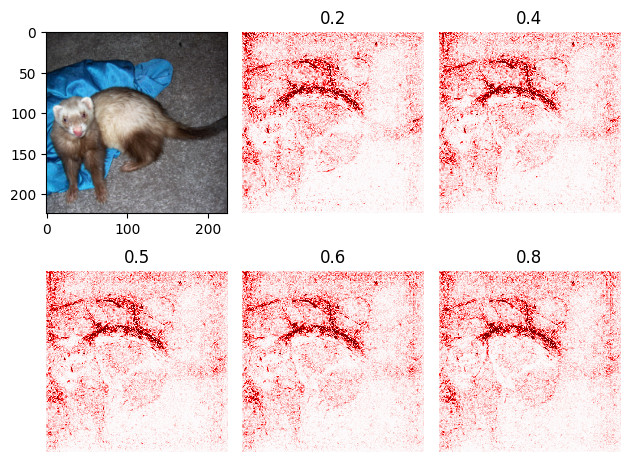

In [18]:
index = 0 
# x,y = valid_datasets[index]
x = ferrot_tensor
y = 22
import numpy as np
import matplotlib.pyplot as plt 
fig, axes = plt.subplots(2, 3) #, figsize=(2*len(names)//2, 2*2))
axes_flat = axes.flat 
my_cmap=plt.cm.seismic(np.arange(plt.cm.seismic.N))

ax = next(axes_flat)
ax.imshow(convert_to_img(x))

for i in [0.2, 0.4, 0.5, 0.6, 0.8]:
    try:
        b_generator =  get_baseline_generator('scalar', scalar = i)
        baseline = b_generator(x=x,y=y)

    except Exception as e: 
        print("-----")
        print("fail:", name)
        print(e)
        continue
        
    attr = ig(model.to(device), x, y, baseline, device=device)
    attr, kwargs  = process_heatmap(attr.cpu(), my_cmap)
    ax = next(axes_flat)
    ax.imshow(attr, **kwargs)
    ax.set_title(f'{i}')
    ax.axis("off")
plt.tight_layout()